In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import scipy

from skimage.feature import hog, local_binary_pattern
from skimage.filters import gabor_kernel
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

C:\Users\Samuel Paendong\AppData\Local\Temp\ipykernel_23828\223091079.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Dataset

In [2]:
class DataLoader:
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images = []
        self.image_labels = []

        if not os.path.exists(self.root_dir):
            raise FileNotFoundError("File not Found")
        else:
            for idx, dir in enumerate(os.listdir(self.root_dir)):
                img_folder = os.path.join(self.root_dir, dir)
                for img in os.listdir(img_folder):
                    img_path = os.path.join(img_folder, img)
                    img = cv2.imread(img_path)
                    if img is not None:
                        self.images.append(img)
                        self.image_labels.append(idx)
                    else:
                        print(f'{img} is none')

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.image_labels[idx]

    def __iter__(self):
        for img, label in zip(self.images, self.image_labels):
            yield img, label

In [3]:
dataPath = os.path.join('..', 'data')
truth_label = {}

for idx, dir in enumerate(os.listdir(dataPath)):
    truth_label[idx] = dir

print(truth_label)

{0: 'anger', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 5: 'sadness', 6: 'surprise'}


In [4]:
img_dataset = DataLoader(dataPath)
len(img_dataset)

981

# Preprocessing

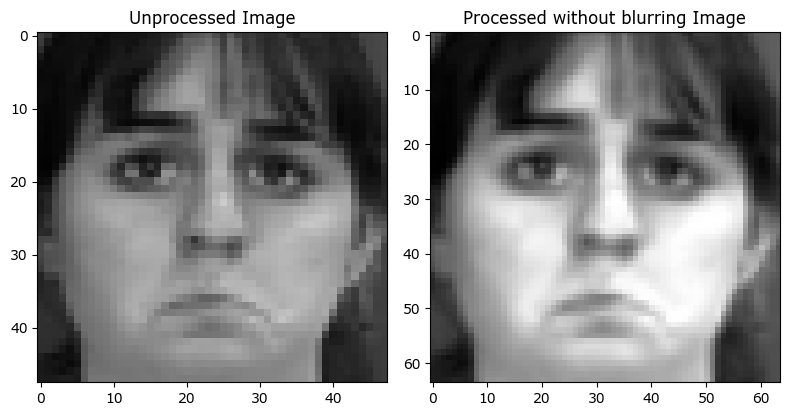

In [5]:
img, _ = img_dataset[710]

gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
resize_img = cv2.resize(gray_img, (64, 64))
equalize_img = cv2.equalizeHist(resize_img)
# final_img = cv2.medianBlur(equalize_img, 3)

plt.figure(figsize=(8,6))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Unprocessed Image")
# plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(equalize_img, 'gray')
plt.title("Processed without blurring Image")
# plt.axis('off')


plt.tight_layout()

In [6]:
def preprocess(img, resize=(64, 64)):
    """
    return processed image in Gray format
    """
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resize_img = cv2.resize(gray_img, resize)
    equalize_img = cv2.equalizeHist(resize_img)
    
    return equalize_img

# plt.imshow(preprocess(img), 'gray')

## Feature Extraction

### Histogram of Gradients

2800

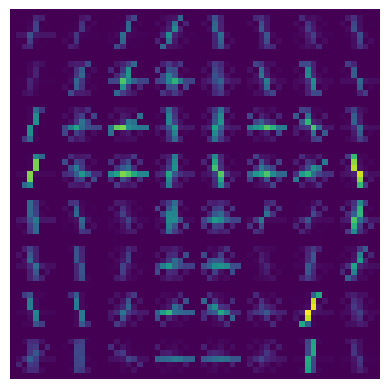

In [7]:
hog_features, hog_image = hog(
    equalize_img,
    orientations=7,               
    pixels_per_cell=(8, 8),      
    cells_per_block=(4, 4),       
    block_norm= 'L2-Hys',
    visualize=True,               
    channel_axis=None           
)

plt.imshow(hog_image)
plt.axis('off')
len(hog_features)

In [9]:
def extract_with_hog(img, orientation=7, pixels_per_cell=(8, 8), cells_per_block=(4,4)):
    """
    return hog features in vector for an image
    """

    hog_features = hog(
        img,
        orientations=orientation,               
        pixels_per_cell=pixels_per_cell,      
        cells_per_block=cells_per_block,
        block_norm = 'L2-Hys',
        visualize=False,               
        channel_axis=None 
    )

    return hog_features

# arr = extract_with_hog(equalize_img)
# len(arr), type(arr)

### Local Binary Pattern

In [10]:
def optimized_lbp(img, method='uniform'):
    P, R = 8, 1  
    
    img = cv2.GaussianBlur(img, (3,3), 0)
    
    lbp = local_binary_pattern(img, P=P, R=R, method=method)
    
    blocks = (8, 8)
    n_bins = P * (P-1) + 3
    features = []
    
    block_h, block_w = img.shape[0] // blocks[0], img.shape[1] // blocks[1]
    
    for i in range(blocks[0]):
        for j in range(blocks[1]):
            block = lbp[i*block_h:(i+1)*block_h, j*block_w:(j+1)*block_w]
            hist, _ = np.histogram(block.ravel(), bins=n_bins, range=(0, n_bins), density=True)
            features.extend(hist)
    
    features = np.array(features)
    features = (features - features.mean()) / (features.std() + 1e-7)
    return features

### Gabor Filter

In [11]:
def optimized_gabor(image, frequencies=[0.1, 0.2], angles=[0, 45, 90, 135]):
    kernels = []
    for theta in angles:
        theta_rad = np.deg2rad(theta)
        for freq in frequencies:
            kernel = gabor_kernel(frequency=freq, theta=theta_rad)
            kernels.append(kernel)

    features = []
    for kernel in kernels:
        filtered = scipy.ndimage.convolve(image, np.real(kernel))
        features.extend([np.mean(filtered), np.std(filtered)])
    
    return np.array(features)

### Waktu Preprocessing + Feature Extraction  

In [19]:
%timeit features_hog = np.array([extract_with_hog(preprocess(img)) for img, _ in img_dataset]) # HOG
%timeit features_lbp = np.array([extract_with_lbp(preprocess(img)) for img, _ in img_dataset]) # LBP
%timeit features_lbp = np.array([extract_with_gabor(preprocess(img)) for img, _ in img_dataset]) # Gabor

2.35 s ± 218 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
51.6 s ± 1.78 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
4min 40s ± 6.94 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Training

In [12]:
# preprocess and extract the feature
features = np.array([extract_with_hog(preprocess(img)) for img, _ in img_dataset])
labels = np.array(img_dataset.image_labels)

# split data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)
X_train.shape, y_train.shape

((784, 2800), (784,))

### Randomized Search and Cross Validation Training with HOG

In [13]:
parameter_svm = {
    'kernel': ['rbf', 'linear', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'C': [0.1, 1, 10, 100]
}

svm = SVC(random_state=42)

random_search = RandomizedSearchCV(
    estimator=svm,
    param_distributions=parameter_svm,
    n_iter=20,    
    cv=5,             
    scoring='accuracy',
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train)

print("Parameter terbaik:")
print(f"Kernel: {random_search.best_params_['kernel']}")
print(f"Gamma: {random_search.best_params_['gamma']}")
print(f"C: {random_search.best_params_['C']}")
print(f"\nSkor terbaik: {random_search.best_score_:.4f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Parameter terbaik:
Kernel: linear
Gamma: 0.01
C: 1

Skor terbaik: 0.9758


In [15]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm = SVC(kernel='linear', gamma=0.01, C=1, probability=True)
scores1 = cross_val_score(svm, X_train, y_train, cv=skf)
print("Cross-validation accuracy scores:", scores1)
print("Mean accuracy:", scores1.mean())

Cross-validation accuracy scores: [0.96178344 0.98089172 0.98089172 0.98089172 0.98076923]
Mean accuracy: 0.9770455658990691


In [16]:
svm.fit(X_train, y_train)
train_output = svm.predict(X_train)
print(classification_report(y_train, train_output))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       108
           1       1.00      1.00      1.00        43
           2       1.00      1.00      1.00       142
           3       1.00      1.00      1.00        60
           4       1.00      1.00      1.00       165
           5       1.00      1.00      1.00        67
           6       1.00      1.00      1.00       199

    accuracy                           1.00       784
   macro avg       1.00      1.00      1.00       784
weighted avg       1.00      1.00      1.00       784



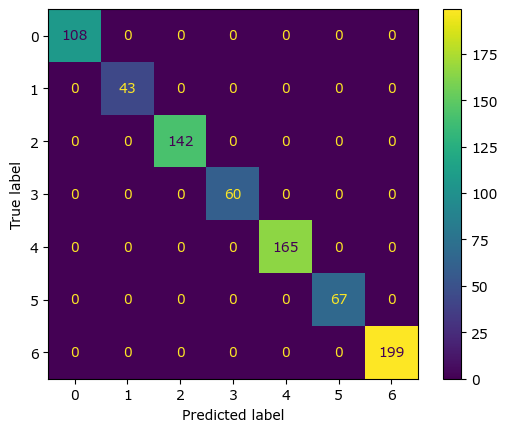

In [17]:
cm = confusion_matrix(y_train, train_output, labels=svm.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_).plot()

## Inference

In [18]:
test_output = svm.predict(X_test)
print(classification_report(y_test, test_output))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00        11
           2       1.00      0.91      0.96        35
           3       1.00      1.00      1.00        15
           4       0.93      1.00      0.97        42
           5       1.00      1.00      1.00        17
           6       1.00      1.00      1.00        50

    accuracy                           0.98       197
   macro avg       0.99      0.99      0.99       197
weighted avg       0.99      0.98      0.98       197



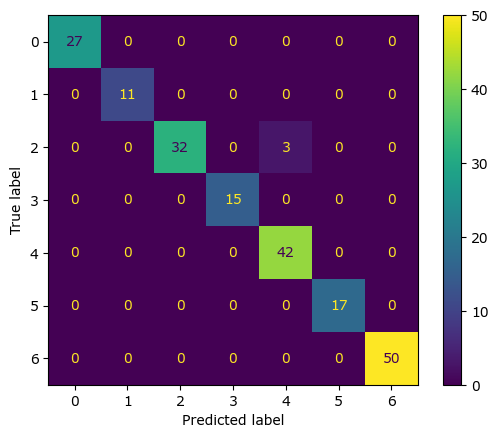

In [19]:
cm = confusion_matrix(y_test, test_output, labels=svm.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_).plot()